In [1]:
import os

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import re



In [63]:
# Complex normal distribution
def cnormal(mean,std,size=1):
    return np.random.normal(np.real(mean), std, size)+1j*np.random.normal(np.imag(mean), std, size)

# Sampling from a discretely specified pdf using inverse transform sampling 
def sample_uniform_discrete(p):
    cdf_p = np.append(0,np.cumsum(p))
    v = np.random.random()
    idx = np.searchsorted(cdf_p,v,side='left')
    if cdf_p[idx]==cdf_p[idx-1]:
        return (idx-1)/(len(cdf_p)-1)
    return (idx+(v-cdf_p[idx-1])/(cdf_p[idx]-cdf_p[idx-1])-1)/(len(cdf_p)-1)

def gibbs_sampler_interference(x,K=20,alpha_dirichlet=np.ones(20),sigma_beta=1,phi_discretization=30,iterations=2): #Take the input data and number of components, and K-Dirichlet hyperparameter
    
    d = np.shape(x)[1]
    n = np.shape(x)[0]
    print('# Data points: ', n)
    print('# Data dimension: ', d)
    print('# Clusters: ', K)
    
    #Initialize Latent Variables (theta,beta,z)
    theta = np.ones(K)*1/K
    beta = cnormal(0,sigma_beta,(K,d))
    z = np.random.choice(K,(n,))
    phi = np.random.random((n,1))
    log_likelihoods = np.zeros(iterations)
    
    for iteration in range(iterations):
        
        log_likelihood = 0
        
        #Sample theta given z
        theta = np.random.dirichlet(alpha_dirichlet+np.sum(z,axis=0))
        log_likelihood += np.log(sp.stats.dirichlet.pdf(theta,alpha_dirichlet))
#         print('Sampled Theta',log_likelihood)
        
        #Sample beta given z and x and phi
        for k in range(K):
            n_k = np.sum(z==k)
            beta[k,:] = (np.sum(x[z==k,:]*np.exp(-2j*np.pi*phi[z==k,:]),axis=0))/(n_k+1/sigma_beta**2)
            log_likelihood += np.sum(np.log(sp.stats.norm.pdf(np.real(beta[k]),0,sigma_beta)))+\
            np.sum(np.log(sp.stats.norm.pdf(np.imag(beta[k]),0,sigma_beta)))
#         print('Sampled beta',log_likelihood)
        
        #Sample phi given beta and z and x
        for i in range(n):
#             p = np.zeros(phi_discretization) #Probability for each of the phi_discretization values
            p_log = np.zeros(phi_discretization)
            for j in range(phi_discretization):
                phi_j = (j+1)/phi_discretization
                p_log[j] = (-np.linalg.norm(beta[z[i],:]*np.exp(2j*np.pi*phi_j)-x[i,:])**2)
            p_log-=np.max(p_log)
            p = np.exp(p_log)
            p = p/np.sum(p)
            phi[i] = sample_uniform_discrete(p)
        #Ignoring p(phi) for log-likelihood as it is a unifrom distribution
#         print('Sampled phi',log_likelihood)
            
        #Sample z_i given beta and x_i and phi
        for i in range(n):
#             p = np.zeros(K) #Probability for each of the K clusters
            p_log = np.zeros(K) #Probability for each of the K clusters
            for k in range(K):
#                 p[k] = theta[k]*np.exp(-np.linalg.norm(beta[k,:]*np.exp(2j*np.pi*phi[i])-x[i,:])**2)
                p_log[k] = (-np.linalg.norm(beta[k,:]*np.exp(2j*np.pi*phi[i])-x[i,:])**2)
            p_log-=np.max(p_log)
            p = theta*np.exp(p_log)
            p = p/np.sum(p)
            z[i] = np.random.choice(K,p=p)
            #p(z_i|\theta)
            log_likelihood += np.log(p[z[i]])
            #p(x_i|z_i,\beta)
            log_likelihood += np.sum(np.log(sp.stats.norm.pdf(np.real(x[i]), np.real(beta[z[i]]*np.exp(2j*np.pi*phi[i])), 1)))+\
            np.sum(np.log(sp.stats.norm.pdf(np.imag(x[i]), np.imag(beta[z[i]]*np.exp(2j*np.pi*phi[i])), 1)))
#         print('Sampled z_i',log_likelihood)
        if not (iteration+1)%max(iterations//10,1):
            print('# Iteration', iteration,'# Log Likelihood:', log_likelihood)
            
        log_likelihoods[iteration] = log_likelihood
                
    return theta,beta,z,phi,log_likelihoods #Return a sample of latent variables from the posterior

In [64]:
x = np.load(os.path.join('dataset', 'interference_samples.npy'))

In [75]:
#Number of clusters
Ks = [2,5,10,15,20,25]
log_likelihoods = [0]*len(Ks)
for k in range(len(Ks)):
    theta,beta,z,phi,log_likelihoods[k] = gibbs_sampler_interference(x,K=Ks[k],alpha_dirichlet=np.ones(Ks[k]),\
                                                              sigma_beta=3,phi_discretization=20,iterations=50)
    

# Data points:  5300
# Data dimension:  512
# Clusters:  2
# Iteration 4 # Log Likelihood: -6308463.379687299
# Iteration 9 # Log Likelihood: -6296640.225840835
# Iteration 14 # Log Likelihood: -6288843.091866741
# Iteration 19 # Log Likelihood: -6286864.671387784
# Iteration 24 # Log Likelihood: -6286305.541953058
# Iteration 29 # Log Likelihood: -6285328.886948121
# Iteration 34 # Log Likelihood: -6284990.382738984
# Iteration 39 # Log Likelihood: -6285081.887427777
# Iteration 44 # Log Likelihood: -6284871.407655892
# Iteration 49 # Log Likelihood: -6285175.983998744
# Data points:  5300
# Data dimension:  512
# Clusters:  5
# Iteration 4 # Log Likelihood: -6231941.537303325
# Iteration 9 # Log Likelihood: -6192993.144317561
# Iteration 14 # Log Likelihood: -6179276.656772073
# Iteration 19 # Log Likelihood: -6174977.481053837
# Iteration 24 # Log Likelihood: -6167536.018714513
# Iteration 29 # Log Likelihood: -6164144.321960237
# Iteration 34 # Log Likelihood: -6161551.989954093
# 

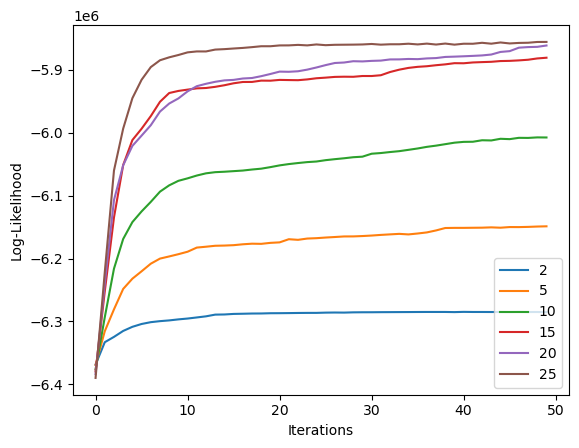

In [76]:
for k in range(len(Ks)):
    plt.plot(log_likelihoods[k],label=str(Ks[k]))
plt.xlabel('Iterations')
plt.ylabel('Log-Likelihood')
plt.legend()

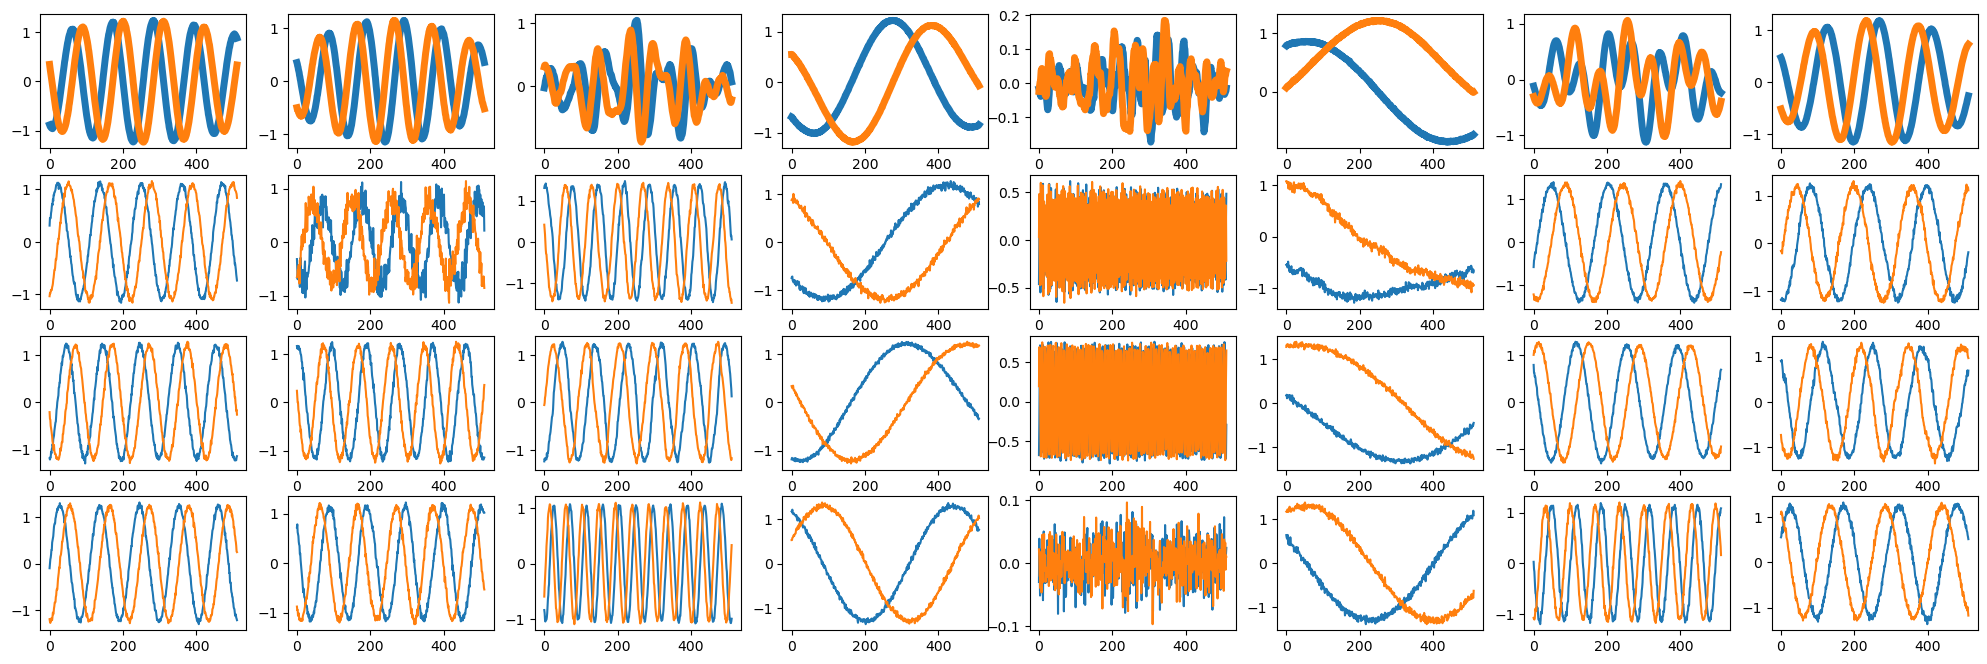

In [77]:
M = 8 #Number of mixture components to plot
F = 0 #Offset
fig, ax = plt.subplots(nrows=4, ncols=M,figsize=(25,8))

for i_row in range(4):
    for i_col in range(M):
        if i_row == 0:
            ax[i_row][i_col].plot(np.real(beta[i_col+F]),linewidth=5.0)
            ax[i_row][i_col].plot(np.imag(beta[i_col+F]),linewidth=5.0)
        else:
            x_col = x[z==i_col+F,:]
            x_col_row = x_col[i_row-1]
            ax[i_row][i_col].plot(np.real(x_col_row))
            ax[i_row][i_col].plot(np.imag(x_col_row))